<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/gaussian_param_inf_1d_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference for the parameters of a 1d Gaussian using a non-conjugate prior

We illustrate various inference methods using the example in sec 4.3 ("Gaussian model of height") of [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/). This requires computing $p(\mu,\sigma|D)$ using a Gaussian likelihood but a non-conjugate prior.
The numpyro code is from [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/04-geocentric-models.html).





In [70]:

import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import math
import os
import warnings
import pandas as pd

#from scipy.interpolate import BSpline
#from scipy.stats import gaussian_kde

In [71]:
!mkdir figures

mkdir: cannot create directory ‘figures’: File exists


In [72]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro


In [73]:

import jax
print("jax version {}".format(jax.__version__))
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

import jax.numpy as jnp
from jax import random, vmap

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

jax version 0.2.12
jax backend gpu


In [74]:
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.distributions.transforms import AffineTransform
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


In [75]:
!pip install arviz
import arviz as az


# Data

We use the "Howell" dataset, which consists of measurements of height, weight, age and sex, of a certain foraging tribe, collected by Nancy Howell.

In [76]:
#url = 'https://github.com/fehiepsi/rethinking-numpyro/tree/master/data/Howell1.csv?raw=True'
url = 'https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv'

Howell1 = pd.read_csv(url, sep=';')
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [77]:
# get data for adults
d2 = d[d.age >= 18]
N = len(d2)
ndx = jax.random.permutation(rng_key, N)
data = d2.height.values[ndx]
N = 20 # take a subset of the 354 samples
data = data[:N]

Empirical mean and std.

In [78]:
print(len(data))
print(np.mean(data))
print(np.std(data))

20
154.16326000000004
7.459859122289108


# Model

We use the following model for the heights (in cm):
$$
\begin{align}
h_i &\sim N(\mu,\sigma) \\
\mu &\sim N(178, 20) \\
\sigma &\sim U(0,50)
\end{align}
$$

The prior for $\mu$ has a mean 178cm, since that is the height of 
Richard McElreath, the author of the "Statisical Rethinking" book.
The standard deviation is 20, so that 90\% of people lie in the range 138--218.

The prior for $\sigma$ has a lower bound of 0 (since it must be positive), and an upper bound of 50, so that the interval $[\mu-\sigma, \mu+\sigma]$ has width 100cm, which seems sufficiently large to capture human heights.


Note that this is not a conjugate prior, so we will just approximate the posterior.
But since there are just 2 unknowns, this will be easy.


# Grid posterior

In [79]:
mu_prior = dist.Normal(178, 20)
sigma_prior = dist.Uniform(0, 50)

mu_range = [150, 160]
sigma_range = [4, 14]
ngrid = 100
plot_square = False

mu_list = jnp.linspace(start=mu_range[0], stop=mu_range[1], num=ngrid)
sigma_list = jnp.linspace(start=sigma_range[0], stop=sigma_range[1], num=ngrid)
mesh = jnp.meshgrid(mu_list, sigma_list)
print([mesh[0].shape, mesh[1].shape])
print(mesh[0].reshape(-1).shape)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(data))
)(post["mu"], post["sigma"])
logprob_mu = mu_prior.log_prob(post["mu"])
logprob_sigma = sigma_prior.log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))
prob = post["prob"] / jnp.sum(post["prob"]) # normalize over the grid

[(100, 100), (100, 100)]
(10000,)


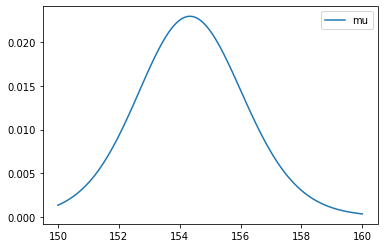

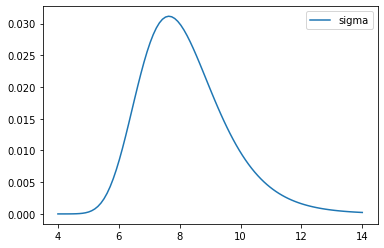

In [80]:
prob2d = prob.reshape(ngrid, ngrid)
prob_mu = jnp.sum(prob2d, axis=0)
prob_sigma = jnp.sum(prob2d, axis=1)

plt.figure()
plt.plot(mu_list, prob_mu, label='mu')
plt.legend()
plt.savefig('figures/gauss_params_1d_post_grid_marginal_mu.pdf', dpi=300)
plt.show()

plt.figure()
plt.plot(sigma_list, prob_sigma, label='sigma')
plt.legend()
plt.savefig('figures/gauss_params_1d_post_grid_marginal_sigma.pdf', dpi=300)
plt.show()

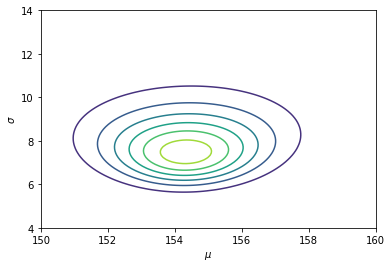

In [81]:
plt.contour(
    post["mu"].reshape(ngrid, ngrid),
    post["sigma"].reshape(ngrid, ngrid),
    post["prob"].reshape(ngrid, ngrid),
)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
if plot_square: plt.axis('square')
plt.savefig('figures/gauss_params_1d_post_grid_contours.pdf', dpi=300)
plt.show()

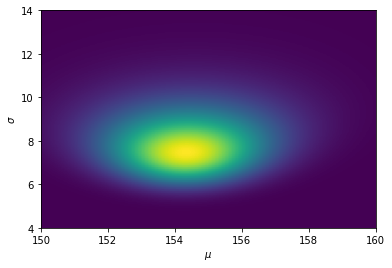

In [82]:
plt.imshow(
    post["prob"].reshape(ngrid, ngrid),
    origin="lower",
    extent=(mu_range[0], mu_range[1], sigma_range[0], sigma_range[1]),
    aspect="auto",
)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
if plot_square: plt.axis('square')
plt.savefig('figures/gauss_params_1d_post_grid_heatmap.pdf', dpi=300)
plt.show()

Posterior samples.

In [83]:

nsamples = 5000 #int(1e4)
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (nsamples,))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]
samples = {'mu': sample_mu, 'sigma': sample_sigma}




                mean       std    median      2.5%     97.5%     n_eff     r_hat
        mu    154.39      1.75    154.34    150.91    157.78   4505.97      1.00
     sigma      8.18      1.41      8.04      5.72     10.97   5065.49      1.00



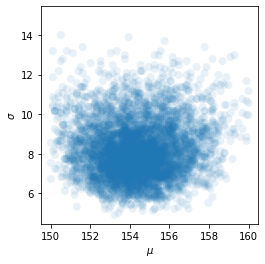

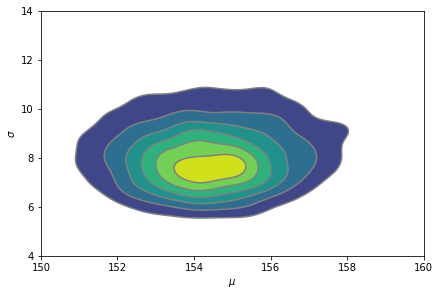

In [84]:
print_summary(samples, 0.95, False)


plt.scatter(samples['mu'], samples['sigma'], s=64, alpha=0.1, edgecolor="none")
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.axis('square')
plt.show()

az.plot_kde(samples['mu'], samples['sigma']);
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
if plot_square: plt.axis('square')
plt.savefig('figures/gauss_params_1d_post_grid.pdf', dpi=300)
plt.show()

posterior marginals.

[150.909 157.778]
[ 5.717 10.97 ]


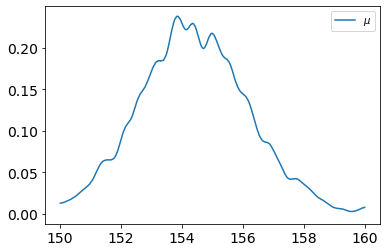

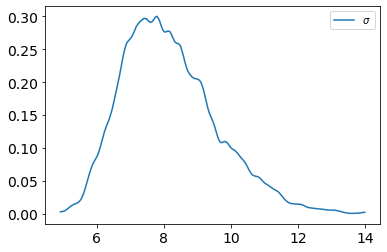

In [85]:
print(hpdi(samples['mu'], 0.95))
print(hpdi(samples['sigma'], 0.95))

fig, ax = plt.subplots()
az.plot_kde(samples['mu'], ax=ax, label=r'$\mu$')

fig, ax = plt.subplots()
az.plot_kde(samples['sigma'], ax=ax, label=r'$\sigma$')


# Laplace approximation

See [the documentation](http://num.pyro.ai/en/stable/autoguide.html#autolaplaceapproximation)

## Optimization

100%|██████████| 2000/2000 [00:01<00:00, 1144.90it/s, init loss: 269.4353, avg. loss [1901-2000]: 75.2568]


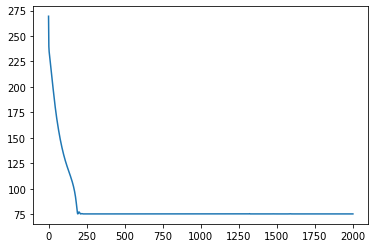

In [140]:
def model(data):
    mu = numpyro.sample("mu", mu_prior)
    sigma = numpyro.sample("sigma", sigma_prior)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=data)

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), data=data)
svi_result = svi.run(random.PRNGKey(0), 2000)

plt.figure()
plt.plot(svi_result.losses)

100%|██████████| 2000/2000 [00:01<00:00, 1128.19it/s, init loss: 75.2585, avg. loss [1901-2000]: 75.2447]


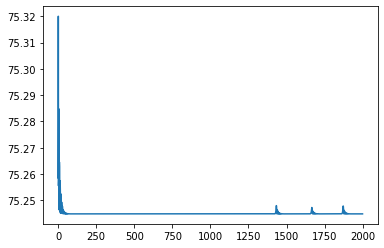

In [135]:
start = {"mu": data.mean(), "sigma": data.std()}
guide = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, guide, optim.Adam(0.1), Trace_ELBO(), data=data)
svi_result = svi.run(random.PRNGKey(0), 2000)

plt.figure()
plt.plot(svi_result.losses)


## Posterior samples.

In [141]:
samples = guide.sample_posterior(random.PRNGKey(1), svi_result.params, (nsamples,))



                mean       std    median      2.5%     97.5%     n_eff     r_hat
        mu    154.32      1.68    154.31    151.06    157.57   4327.88      1.00
     sigma      7.70      1.25      7.59      5.45     10.22   4173.88      1.00



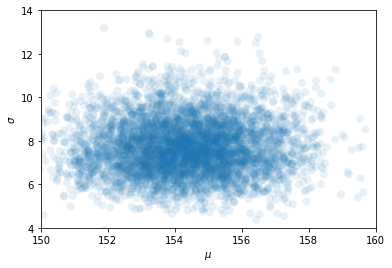

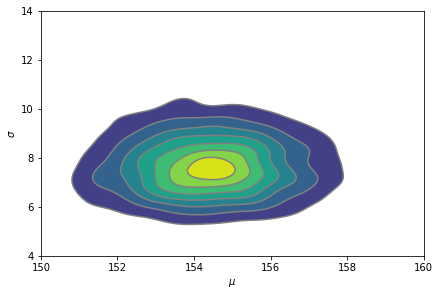

In [142]:
print_summary(samples, 0.95, False)


plt.scatter(samples['mu'], samples['sigma'], s=64, alpha=0.1, edgecolor="none")
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

az.plot_kde(samples['mu'], samples['sigma']);
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
if plot_square: plt.axis('square')
plt.savefig('figures/gauss_params_1d_post_laplace.pdf', dpi=300)
plt.show()

[151.06  157.569]
[ 5.446 10.217]


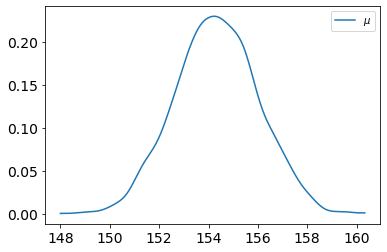

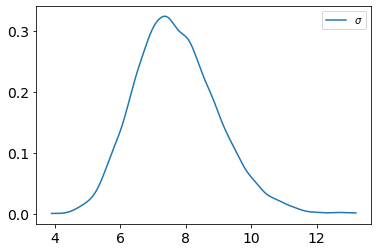

In [90]:
print(hpdi(samples['mu'], 0.95))
print(hpdi(samples['sigma'], 0.95))

fig, ax = plt.subplots()
az.plot_kde(samples['mu'], ax=ax, label=r'$\mu$')

fig, ax = plt.subplots()
az.plot_kde(samples['sigma'], ax=ax, label=r'$\sigma$')

## Extract 2d joint posterior

The Gaussian approximation is over transformed parameters.

In [143]:
post = guide.get_posterior(svi_result.params)
print(post.mean)
print(post.covariance_matrix)


[154.335  -1.716]
[[2.885 0.01 ]
 [0.01  0.036]]


In [134]:
def logit(p):
  return jnp.log(p/(1-p))

def sigmoid(a):
  return 1/(1+jnp.exp(-a))

scale=50; print(logit(7.7/scale)); print(sigmoid(-1.7)*scale)

-1.7035668
7.723263


In [148]:
unconstrained_samples = post.sample(rng_key, sample_shape=(nsamples,))
constrained_samples = guide._unpack_and_constrain(unconstrained_samples, svi_result.params)

print(unconstrained_samples.shape)
print(jnp.mean(unconstrained_samples, axis=0))
print(jnp.mean(constrained_samples['mu'], axis=0))
print(jnp.mean(constrained_samples['sigma'], axis=0))



(5000, 2)
[154.326  -1.724]
154.32643
7.6484103


We can sample from the posterior, which return results in the original parameterization.

In [92]:
samples = guide.sample_posterior(random.PRNGKey(1), params, (nsamples,))
x = jnp.stack(list(samples.values()), axis=0)
print(x.shape)
print('mean of ssamples\n', jnp.mean(x, axis=1))
vcov = jnp.cov(x)
print('cov of samples\n', vcov) # variance-covariance matrix

# correlation matrix
R = vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov)))
print('corr of samples\n', R)



(2, 5000)
mean of ssamples
 [154.324   7.702]
cov of samples
 [[2.839 0.051]
 [0.051 1.56 ]]
corr of samples
 [[1.    0.024]
 [0.024 1.   ]]


# Variational inference

We use
$q(\mu,\sigma) = N(\mu|m,s) Ga(\sigma|a,b)$


100%|██████████| 2000/2000 [00:03<00:00, 518.24it/s, init loss: 75.1782, avg. loss [1901-2000]: 74.7501]


{'a': DeviceArray(22.394, dtype=float32), 'b': DeviceArray(2.443, dtype=float32), 'm': DeviceArray(154.246, dtype=float32), 's': DeviceArray(1.785, dtype=float32)}
(2000,)


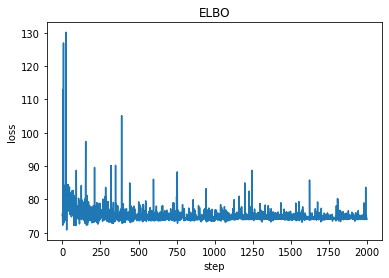

In [124]:



def guide(data):
  data_mean = jnp.mean(data)
  data_std = jnp.std(data)
  m = numpyro.param("m", data_mean) 
  s = numpyro.param("s", 10, constraint=constraints.positive) 
  a = numpyro.param("a", data_std, constraint=constraints.positive) 
  b = numpyro.param("b", 1, constraint=constraints.positive) 
  mu = numpyro.sample("mu", dist.Normal(m, s))
  sigma = numpyro.sample("sigma", dist.Gamma(a, b))

optimizer = numpyro.optim.Momentum(step_size=0.001, mass=0.1)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
nsteps = 2000
svi_result = svi.run(rng_key_, nsteps, data=data)

print(svi_result.params)
print(svi_result.losses.shape)
plt.plot(svi_result.losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

## Extract Variational parameters.


In [125]:
print(svi_result.params)
a = np.array(svi_result.params['a'])
b = np.array(svi_result.params['b'])
m = np.array(svi_result.params['m'])
s = np.array(svi_result.params['s'])


{'a': DeviceArray(22.394, dtype=float32), 'b': DeviceArray(2.443, dtype=float32), 'm': DeviceArray(154.246, dtype=float32), 's': DeviceArray(1.785, dtype=float32)}


In [126]:
print('empirical mean', jnp.mean(data))
print('empirical std', jnp.std(data))

print(r'posterior mean and std of $\mu$')
post_mean = dist.Normal(m, s)
print([post_mean.mean, jnp.sqrt(post_mean.variance)])

print(r'posterior mean and std of unconstrained $\sigma$')
post_sigma = dist.Gamma(a,b)
print([post_sigma.mean, jnp.sqrt(post_sigma.variance)])

empirical mean 154.16325
empirical std 7.459859
posterior mean and std of $\mu$
[array(154.246, dtype=float32), DeviceArray(1.785, dtype=float32)]
posterior mean and std of unconstrained $\sigma$
[9.165675, DeviceArray(1.937, dtype=float32)]


## Posterior samples

In [96]:
predictive = Predictive(guide, params=svi_result.params, num_samples=nsamples)
samples = predictive(rng_key, data)




                mean       std    median      2.5%     97.5%     n_eff     r_hat
        mu    154.32      1.79    154.29    150.85    157.88   4950.79      1.00
     sigma      9.17      1.91      9.01      5.56     12.88   5093.46      1.00



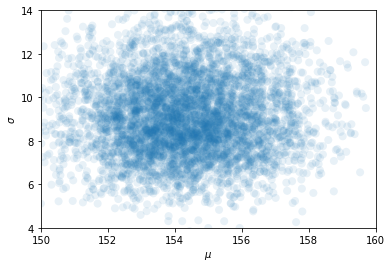

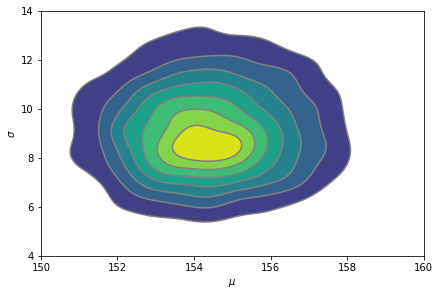

In [97]:
print_summary(samples, 0.95, False)


plt.scatter(samples['mu'], samples['sigma'], s=64, alpha=0.1, edgecolor="none")
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

az.plot_kde(samples['mu'], samples['sigma']);
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
if plot_square: plt.axis('square')
plt.savefig('figures/gauss_params_1d_post_vi.pdf', dpi=300)
plt.show()

[150.846 157.881]
[ 5.559 12.877]


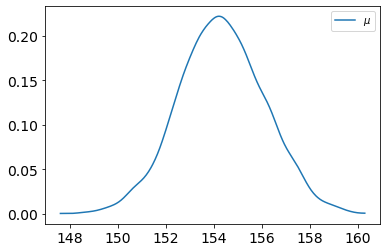

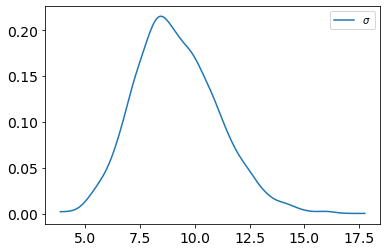

In [98]:
print(hpdi(samples['mu'], 0.95))
print(hpdi(samples['sigma'], 0.95))

fig, ax = plt.subplots()
az.plot_kde(samples['mu'], ax=ax, label=r'$\mu$')

fig, ax = plt.subplots()
az.plot_kde(samples['sigma'], ax=ax, label=r'$\sigma$')

# MCMC

In [99]:
conditioned_model = numpyro.handlers.condition(model, {'data': data})
nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=nsamples)
mcmc.run(rng_key_, data)

mcmc.print_summary()
samples  = mcmc.get_samples()

sample: 100%|██████████| 5100/5100 [00:19<00:00, 266.79it/s, 3 steps of size 1.66e-01. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu    154.34      1.86    154.33    151.36    157.39   3652.68      1.00
     sigma      8.24      1.51      8.05      5.88     10.36   2806.00      1.00

Number of divergences: 0



                mean       std    median      2.5%     97.5%     n_eff     r_hat
        mu    154.34      1.86    154.33    150.70    158.08   3652.68      1.00
     sigma      8.24      1.51      8.05      5.67     11.04   2806.00      1.00



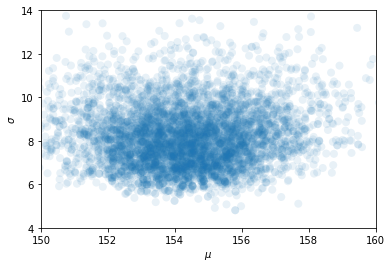

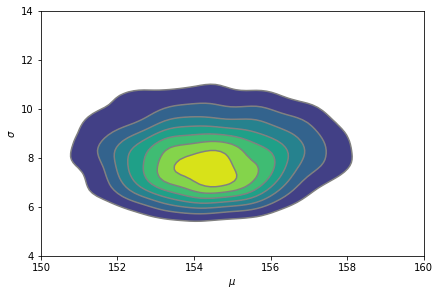

In [100]:
print_summary(samples, 0.95, False)


plt.scatter(samples['mu'], samples['sigma'], s=64, alpha=0.1, edgecolor="none")
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

az.plot_kde(samples['mu'], samples['sigma']);
plt.xlim(mu_range[0], mu_range[1])
plt.ylim(sigma_range[0], sigma_range[1])
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
if plot_square: plt.axis('square')
plt.savefig('figures/gauss_params_1d_post_mcmc.pdf', dpi=300)
plt.show()